Import libraries

In [1]:
from helpers import load_csv_data, create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from common import batch_iter, sigmoid
from mie import build_k_indices, cross_validation, logistic_loss, train_val_split, subsample_class
from performance import accuracy, precision, recall, f1_score

Load data

In [21]:
data_path='data/dataset/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) 
print("Data type y_train:", y_train.dtype) 

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


Check types of variables

Total categorical features (<= 20 unique): 241
Total continuous features    (>  20 unique): 80


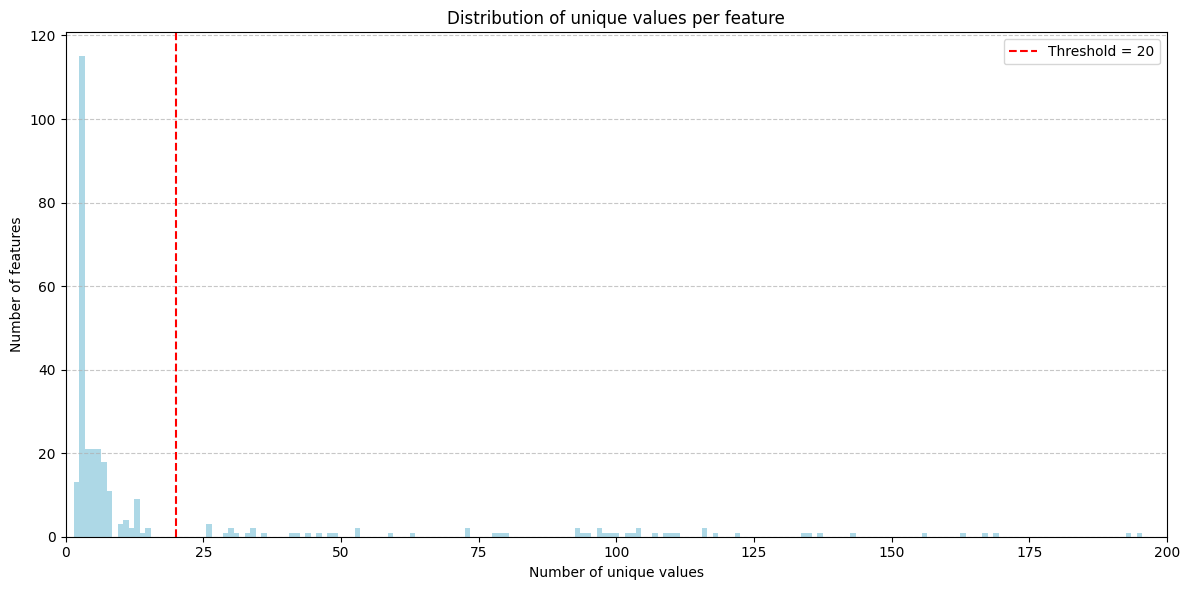

In [ ]:
# Fixed threshold
threshold = 20
categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train.shape[1]):
    col = x_train[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)
    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

# Classifies features as categorical or continuous
print(f"Total categorical features (<= {threshold} unique): {len(categorical_idx)}")
print(f"Total continuous features    (>  {threshold} unique): {len(continuous_idx)}")

# Build histrogram
unique_counts = np.array(unique_counts)
unique_vals, counts = np.unique(unique_counts, return_counts=True)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unique_vals, counts, color='lightblue', width=1.0)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Number of unique values')
plt.xlim(right=200)
plt.xlim(left=0)
plt.ylabel('Number of features')
plt.title('Distribution of unique values per feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Data cleaning from NaN

Number of features with more than 40% of NaN: 159
Shape after dropping cols >40% NaN: (328135, 162)
Categorical features: 105
Continuous features: 57
Missing values imputed (mean for continuous, mode for categorical)
Shape x_train_clean: (328135, 162)


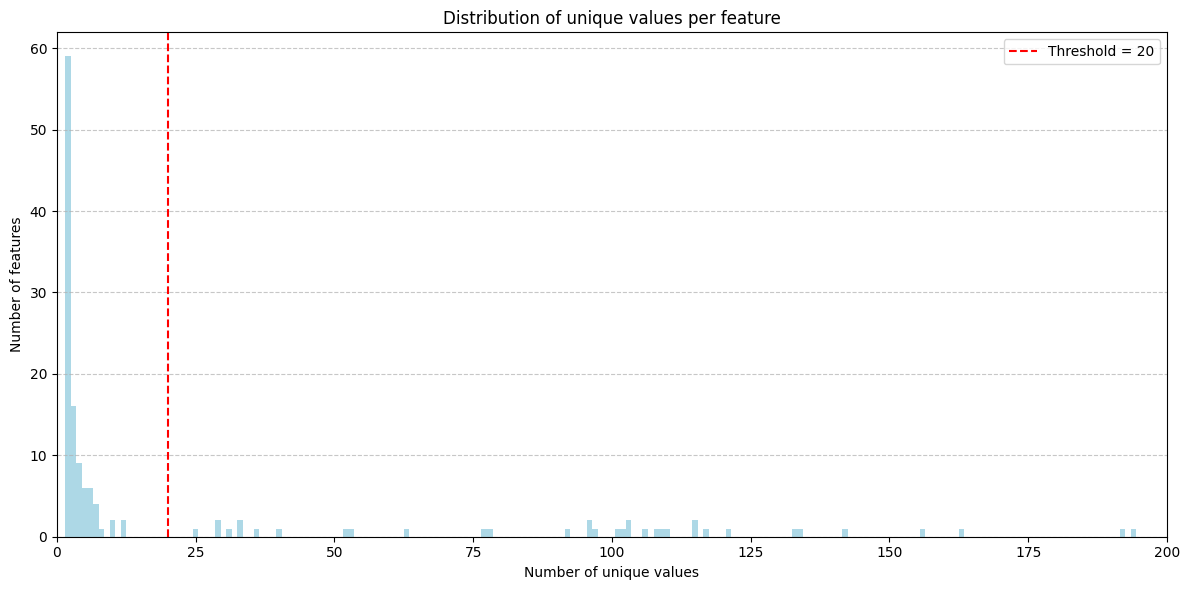

In [26]:
nan_ratio = np.mean(np.isnan(x_train), axis=0)
print(f"Number of features with more than 40% of NaN: {np.sum(nan_ratio>0.4)}")

# 1 Drop feature if at least 40% are NaN values
valid_cols = np.where(nan_ratio < 0.4)[0]
x_train_clean = x_train[:, valid_cols]
x_test_clean = x_test[:, valid_cols]
print(f"Shape after dropping cols >40% NaN: {x_train_clean.shape}")

# 2 Identify categorical vs continuous
categorical_idx = []
continuous_idx = []
unique_counts = []
for i in range(x_train_clean.shape[1]):
    count = len(np.unique(x_train_clean[~np.isnan(x_train_clean[:, i]), i]))
    unique_counts.append(count)
    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

print(f"Categorical features: {len(categorical_idx)}")
print(f"Continuous features: {len(continuous_idx)}")

# 4. Impute NaN differently
# 4a. Continuous → replace NaN with mean
for i in continuous_idx:
    mean_val = np.nanmean(x_train_clean[:, i])
    x_train_clean[np.isnan(x_train_clean[:, i]), i] = mean_val
    x_test_clean[np.isnan(x_test_clean[:, i]), i] = mean_val

# 4b. Categorical → replace NaN with mode
def nanmode(col):
    vals, counts = np.unique(col[~np.isnan(col)], return_counts=True)
    return vals[np.argmax(counts)] if len(vals) > 0 else np.nan

for i in categorical_idx:
    mode_val = nanmode(x_train_clean[:, i])
    x_train_clean[np.isnan(x_train_clean[:, i]), i] = mode_val
    x_test_clean[np.isnan(x_test_clean[:, i]), i] = mode_val

print("Missing values imputed (mean for continuous, mode for categorical)")
print("Shape x_train_clean:", x_train_clean.shape)

# Build histrogram
unique_counts = np.array(unique_counts)
unique_vals, counts = np.unique(unique_counts, return_counts=True)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unique_vals, counts, color='lightblue', width=1.0)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Number of unique values')
plt.xlim(right=200)
plt.xlim(left=0)
plt.ylabel('Number of features')
plt.title('Distribution of unique values per feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Data cleaning: highly correlated features (multicollinearity, e.g. different scales)

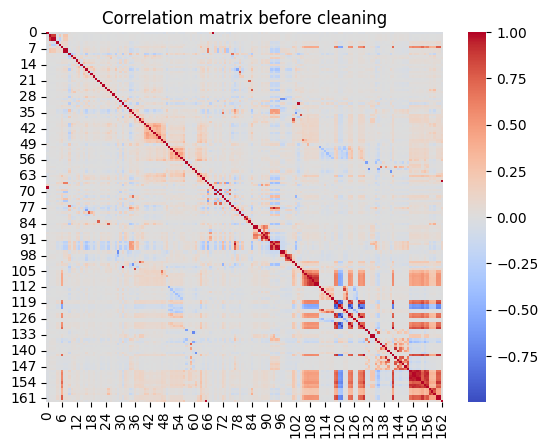

Shape of decorrelated X: (328135, 128)


In [9]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_clean.shape[1]):
    for j in range(i + 1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

x_train_decorr = np.delete(x_train_clean, list(non_valid_col), axis=1)     # Remove column
x_test_decorr = np.delete(x_test_clean, list(non_valid_col), axis=1)
print(f"Shape of decorrelated X: {x_train_decorr.shape}")

Data cleaning: remove low informative features

In [10]:
def drop_low_info_features(X, cont_indices, cat_indices, var_thresh, mode_thresh):
    """
    Removes low-variance features (for continuous variables)
    and high-mode features (for categorical variables),

    """
    
    n_samples = X.shape [0]
    n_features = X.shape [1]
    keep_mask = np.ones(n_features, dtype=bool)
    
    # 1️  continuos feature: variance
    for i in cont_indices:
        var = np.var(X[:, i].astype(float))
        if var < var_thresh:
            keep_mask[i] = False

    # 2️  categorical feature:  mode
    for i in cat_indices:
        col = X[:, i]
        # Find the most frequent value (mode) and its relative frequency, if the latter overcomes a threshold the feaature is dropped since non-informative
        values, counts = np.unique(col, return_counts=True)
        freq_max = counts.max() / n_samples
        if freq_max > mode_thresh:
            keep_mask[i] = False

    # 3️  Filtering valid columns
    X_filtered = X[:, keep_mask]
    
    print(f"Shape after feature removal: {X_filtered.shape}")
    return X_filtered

# Fixed threshold
threshold = 20
categorical_idx = []
continuous_idx = []
unique_counts = []

# Compute unique values for every column
for i in range(x_train_decorr.shape[1]):
    col = x_train_decorr[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)

    if count <= threshold:
        categorical_idx.append(i)
    else:
        continuous_idx.append(i)

x_train_inf= drop_low_info_features(x_train_decorr, cont_indices=continuous_idx, cat_indices=categorical_idx, var_thresh=1e-3, mode_thresh=0.95)
x_test_inf= drop_low_info_features(x_test_decorr, cont_indices=continuous_idx, cat_indices=categorical_idx, var_thresh=1e-3, mode_thresh=0.95)

Shape after feature removal: (328135, 120)
Shape after feature removal: (109379, 120)


Correlation with output

In [11]:
correlations = np.empty(x_train_inf.shape[1])

for i in range(x_train_inf.shape[1]):
    correlations[i] = np.corrcoef(x_train_inf[:, i], y_train)[0, 1]
    
valid_features=np.where(np.abs(correlations)>=0.05)[0]
x_train_denoised=x_train_inf[:,valid_features]
x_test_denoised=x_test_inf[:,valid_features]

print(f"Shape after denoising: {x_train_denoised.shape}")

Shape after denoising: (328135, 45)


Check linearly dependent features

In [12]:
rank = np.linalg.matrix_rank(x_train_denoised)

print(f"Number of features: {x_train_denoised.shape[1]}")
print(f"Rank of the matrix: {rank}")

if rank < x_train_denoised.shape[1]:
    print("Some features are linearly dependent!")


Number of features: 45
Rank of the matrix: 45


Z-score normalization

In [13]:
col_mean_0=np.mean(x_train_denoised, axis=0)
col_sd_0=np.std(x_train_denoised, axis=0)

x_train_norm = (x_train_denoised-col_mean_0) / col_sd_0
x_test_norm = (x_test_denoised - col_mean_0) / col_sd_0

col_mean=np.mean(x_train_norm, axis=0)
col_sd=np.std(x_train_norm, axis=0)

print(f"Before normalization, mean: {col_mean_0[0:5]}, sd: {col_sd_0[0:5]}")
print(f"After normalization, mean: {col_mean[0:5]}, sd: {col_sd[0:5]}")

Before normalization, mean: [2.01500520e+09 2.57200542e+00 6.07248136e+01 1.57375166e+00
 2.21215049e+00], sd: [4.11846911e+03 1.11467034e+00 3.70522863e+01 1.24516579e+00
 1.03262247e+00]
After normalization, mean: [-2.12228099e-11  1.61985273e-16 -1.20214754e-16 -1.58290563e-17
 -1.40122878e-16], sd: [1. 1. 1. 1. 1.]


Classes distribution

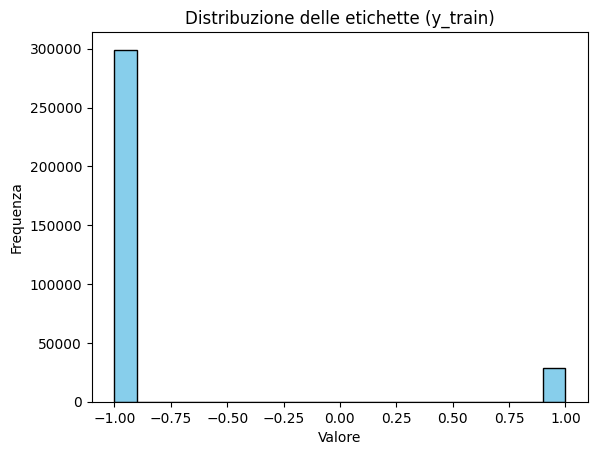

In [14]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Save

In [15]:
np.save("processed/x_train.npy", x_train_norm)
np.save("processed/x_test.npy", x_test_norm)
np.save("processed/y_train.npy", y_train)
np.save("processed/train_ids.npy", train_ids)
np.save("processed/test_ids.npy", test_ids)